In [ ]:
import numpy as np  
import pandas as pd  
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
pd.options.display.max_rows = 100

In [ ]:
 
image_dir = 'C:\Users\Roberto\Desktop\MCC616_InformeFinal_G6-main\fotos_manometro'
labels_dir = 'C:\Users\Roberto\Desktop\MCC616_InformeFinal_G6-main\fotos_manometro\data_manometro.csv'

SyntaxError: ignored

In [ ]:
labels = pd.read_csv(labels_dir)
labels.describe()

FileNotFoundError: ignored

In [ ]:
#distribution de clases de presion
labels.Clase_presion.value_counts(normalize=True)

1    0.87
0    0.13
Name: Clase_presion, dtype: float64

<PIL.Image.Image image mode=RGB size=300x300 at 0x7FE6059EB3D0>


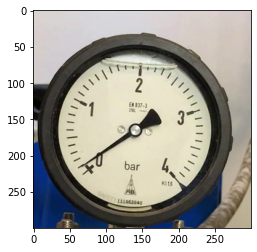

In [ ]:
tot = Image.open('/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/fotos_manometro/0.jpg')
tot.size
tot = tot.resize((300, 300), Image.ANTIALIAS)
tot.size
print(tot)
plt.imshow(tot)

ValueError: ignored

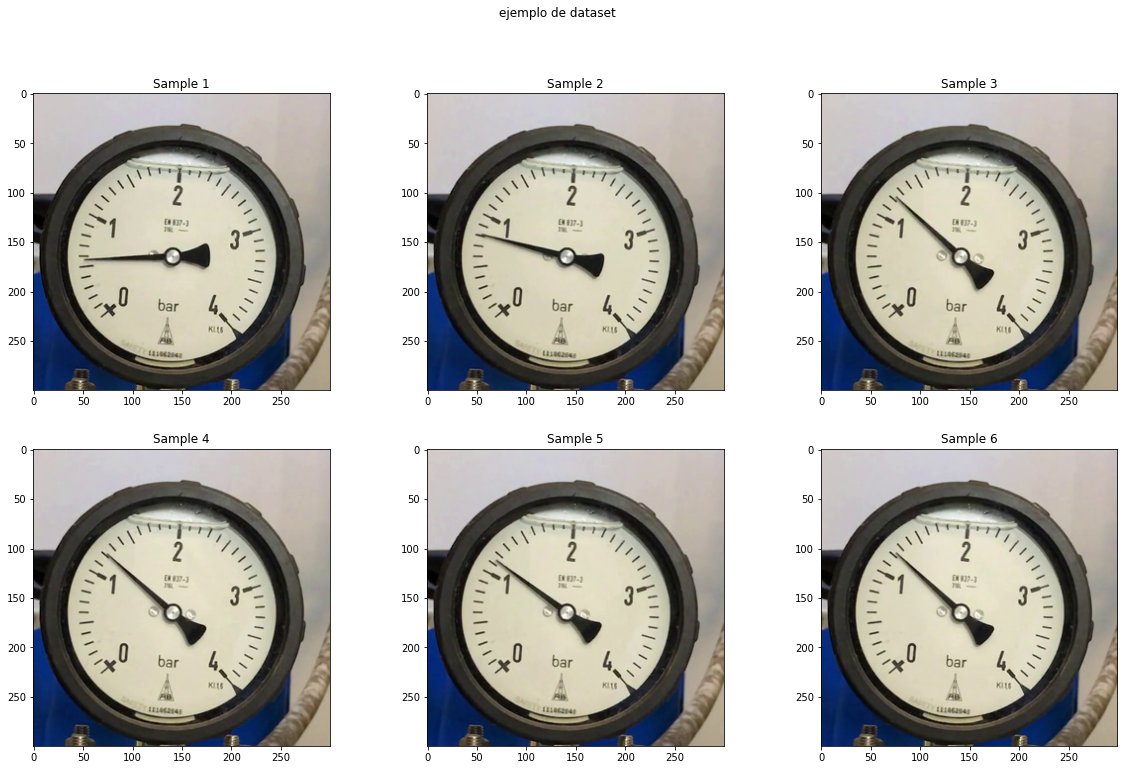

In [ ]:
 
sample_dir = '/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/fotos_manometro'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('ejemplo de dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = img.resize((300, 300), Image.ANTIALIAS)
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

In [ ]:
 
labels_df = pd.read_csv(labels_dir)
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
 
labels_df = labels_df.drop(columns=['Clase_presion'])
 
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

In [ ]:
labels_df

,tuples
0,"(0,)"
1,"(0,)"
2,"(0,)"
3,"(0,)"
4,"(0,)"
...,...
495,"(0,)"
496,"(0,)"
497,"(0,)"
498,"(0,)"


In [ ]:
 
labels_df.head()

,tuples
0,"(0,)"
1,"(0,)"
2,"(0,)"
3,"(0,)"
4,"(0,)"


In [ ]:
 
labels_df['tuples'].value_counts()

(1,)    435
(0,)     65
Name: tuples, dtype: int64

In [ ]:
 
train, test = train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [ ]:
train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

[    tuples
 30    (1,)
 435   (1,)
 81    (1,)
 402   (1,)
 467   (0,)
 ..     ...
 190   (1,)
 96    (1,)
 434   (1,)
 116   (1,)
 335   (1,)
 
 [400 rows x 1 columns],     tuples
 321   (1,)
 316   (1,)
 454   (1,)
 222   (1,)
 288   (1,)
 83    (1,)
 121   (1,)
 371   (1,)
 366   (1,)
 226   (1,)
 473   (0,)
 313   (1,)
 182   (1,)
 387   (1,)
 414   (1,)
 61    (1,)
 233   (1,)
 234   (1,)
 221   (1,)
 408   (1,)
 177   (1,)
 70    (1,)
 68    (1,)
 55    (1,)
 358   (1,)
 449   (1,)
 277   (1,)
 452   (1,)
 477   (0,)
 73    (1,)
 227   (1,)
 183   (1,)
 380   (1,)
 228   (1,)
 486   (0,)
 291   (1,)
 199   (1,)
 309   (1,)
 458   (0,)
 463   (0,)
 251   (1,)
 238   (1,)
 275   (1,)
 303   (1,)
 237   (1,)
 410   (1,)
 208   (1,)
 18    (0,)
 281   (1,)
 399   (1,)
 85    (1,)
 74    (1,)
 101   (1,)
 14    (0,)
 126   (1,)
 489   (0,)
 156   (1,)
 348   (1,)
 330   (1,)
 192   (1,)
 159   (1,)
 29    (1,)
 300   (1,)
 62    (1,)
 324   (1,)
 22    (1,)
 210   (1,)
 53    (1,)
 4

In [ ]:
random.shuffle(os.listdir(image_dir))

#Se tiene q modificar a partir de acá

In [ ]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):
    
   
    prebuilt_model = xception.Xception(include_top=True,                      
              weights='imagenet')                                             
    
    xception_model = Model(inputs=prebuilt_model.input,        
                           outputs=prebuilt_model.layers[-2].output)          
    
    
    
    while 1:
        
        if train_idx==None:
            image_filenames = os.listdir(image_directory)                     
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]
            
        random.shuffle(image_filenames)                                       

        
        image_batch = []                                                      
        labels_batch = []                                                     
        
        for file in image_filenames:                                          

            index = int(file.split('.')[0])                                    
            
            img = image.load_img(os.path.join(image_directory, file),         
                                 target_size=size,
                                 interpolation='box')
            
            img_arr = image.img_to_array(img, dtype='float32')                
            
            label = labels[index]                                             
    
            image_batch.append(img_arr)                                       
            labels_batch.append(label)                                        

    
            if len(image_batch)==batch_size:                                  
                image_batch = np.array(image_batch)                           
                image_batch = xception.preprocess_input(image_batch)         
                image_features = xception_model.predict(image_batch)          
                image_batch = np.array(image_features)                        
                image_batch = image_batch.reshape(batch_size,                 
                                                  image_features.shape[1])   
                labels_batch = np.array(labels_batch)                         
                yield image_batch, labels_batch                               
                image_batch = []                                              
                labels_batch = []                                             
                gc.collect()                                                  

In [ ]:

BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) 
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [ ]:
 
sample_generator = next(generate(image_directory=image_dir, 
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=1, 
                                 size=IMAGE_SIZE))

In [ ]:
 
sample_generator

(array([[0.12008145, 0.27771273, 0.07833042, ..., 0.18653603, 0.21664329,
         0.2076816 ]], dtype=float32), array([[1, 0]]))

In [ ]:
 
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [ ]:
print(INPUT_DIM, OUTPUT_DIM)

(2048,) 2


In [ ]:
def create_model(input_shape, output_shape):

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)
    
    
    model = Model(inputs=input_layer,
                  outputs=output1)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    
    return model

In [ ]:
 
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [ ]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 599,042
Trainable params: 594,946
Non-trainable params: 4,096
_________________________________________________________________


In [ ]:
 
generator = generate(image_directory=image_dir,
                     labels=y,
                     train_idx=train_idx,
                     batch_size=BATCH_SIZE, 
                     size=IMAGE_SIZE)

In [ ]:
#fitting model
history = model.fit(generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS)

Epoch 1/10
1/1 [==============================] - 1s 807ms/step - loss: 0.7704 - accuracy: 0.2188
Epoch 2/10
1/1 [==============================] - 146s 146s/step - loss: 0.2637 - accuracy: 0.9570
Epoch 3/10
1/1 [==============================] - 86s 86s/step - loss: 0.1160 - accuracy: 0.9844
Epoch 4/10
1/1 [==============================] - 86s 86s/step - loss: 0.0605 - accuracy: 0.9961
Epoch 5/10
1/1 [==============================] - 86s 86s/step - loss: 0.0380 - accuracy: 0.9922
Epoch 6/10
1/1 [==============================] - 86s 86s/step - loss: 0.0237 - accuracy: 0.9961
Epoch 7/10
1/1 [==============================] - 86s 86s/step - loss: 0.0211 - accuracy: 0.9922
Epoch 8/10
1/1 [==============================] - 85s 85s/step - loss: 0.0181 - accuracy: 0.9922
Epoch 9/10
1/1 [==============================] - 86s 86s/step - loss: 0.0097 - accuracy: 0.9961
Epoch 10/10
1/1 [==============================] - 85s 85s/step - loss: 0.0108 - accuracy: 0.9922


In [ ]:
def predict(image_directory, indices=None, plot=False):

    images_list = []
    
    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')            
    
    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output)  
    
    if indices!=None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)
    
    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim, 
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)
        
#         axs = axs.flatten()
        
    
    
    for i, file in enumerate(image_filenames):
        

        img = image.load_img(os.path.join(image_directory,
                                          file))
        img = img.resize((299, 299), Image.ANTIALIAS)                     
        img_arr = image.img_to_array(img, dtype='float32')            
    
        if plot:
            axs.flat[i].imshow(img_arr/255.0)
            
        images_list.append(img_arr)
        gc.collect()       
    
    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)                  
    print('extracting features...')
    img_features = xception_model.predict(img_arr)                    
    img_features = np.array(img_features)
    print('predicting...')
    prediction = model.predict(img_features)                                                 
    Clase_presion_max = np.argmax(prediction[:, :2], axis=1)                  
    
    prediction_list = [binarizer.classes_[x] for x in list(zip(Clase_presion_max))]

    if plot:                                                          
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')
        for j in range(i+1, dim**2):                                  
              fig.delaxes(axs.flat[j])
            
    return prediction_list

preprocessing...
extracting features...
predicting...


IndexError: ignored

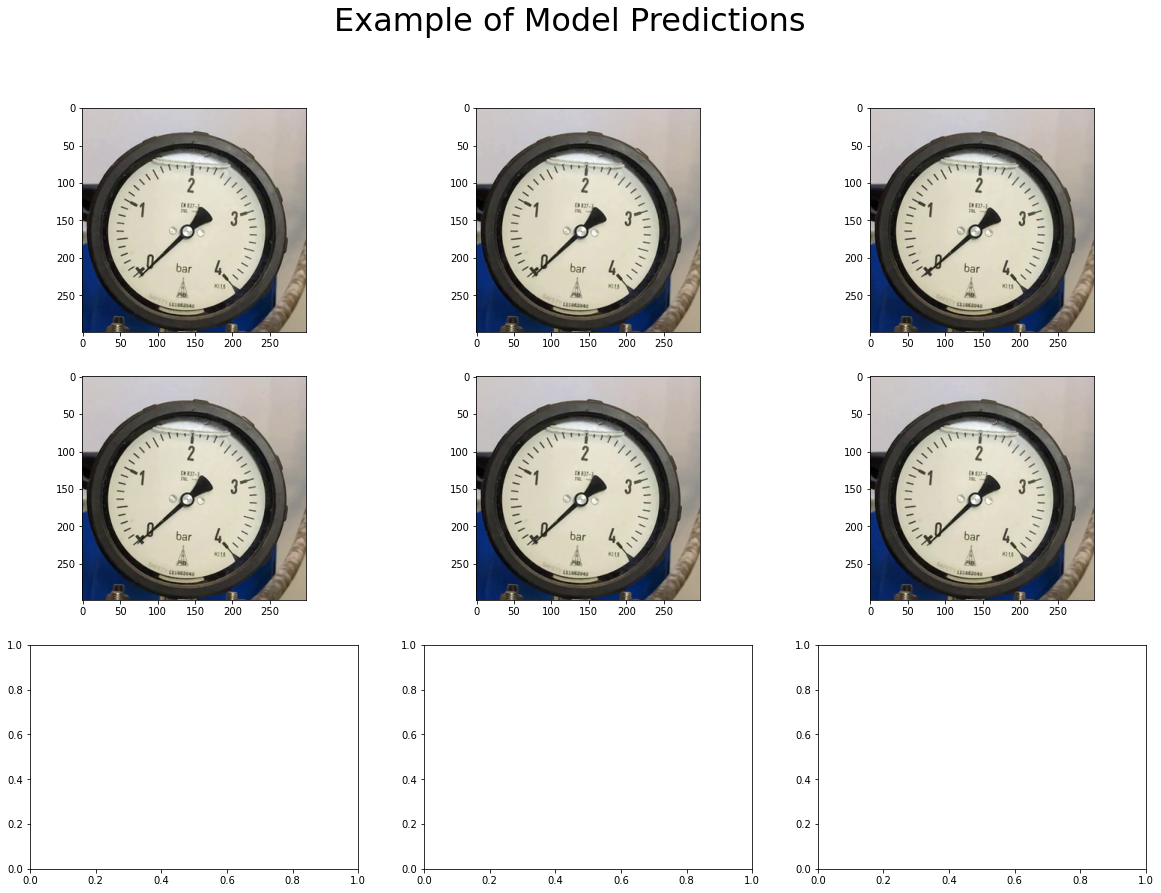

In [ ]:
 
predictions = predict('/content/drive/MyDrive/Maestria 2 ciclo/Trabajo_imagenes/samples',
                        plot=True)